# Lesson 1 - Identify teacup varieties

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Get four types of tea cup images from google: Royal Albert, Paragon, Aynsley, and Shelley. 

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [ ]:
folder = 'royal_albert'
file = 'royal_albert_urls.txt'

In [ ]:
folder = 'paragon'
file = 'paragon_urls.txt'

In [ ]:
folder = 'aynsley'
file = 'aynsley_urls.txt'

In [ ]:
folder = 'shelley'
file = 'shelley_urls.txt'

In [ ]:
path = Path('../data/teacups')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Finally, upload your urls file. Now you will need to download you images from their respective urls.

In [ ]:
download_images(path/file, dest, max_pics=500)

Let's take a look at some of our pictures then.

In [4]:
classes = ['royal_albert','paragon','aynsley','shelley']

In [5]:
path = Path('../data/teacups')

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

royal_albert


paragon


aynsley


shelley


In [7]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=bs)

In [8]:
data.normalize(imagenet_stats)

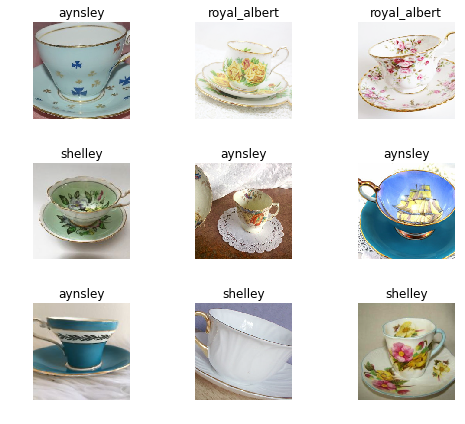

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes),data.c

['aynsley', 'paragon', 'royal_albert', 'shelley']


(4, 4)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 4 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.405196    1.085666    0.431611    (00:18)
2      1.179190    1.007143    0.364742    (00:16)
3      0.996045    0.991944    0.379939    (00:16)
4      0.898543    0.968914    0.379939    (00:15)



In [13]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [14]:
valid = learn.get_preds()

In [ ]:
valid[0] #predictions on validation set

In [ ]:
valid[1] #targets / labels -> 356

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

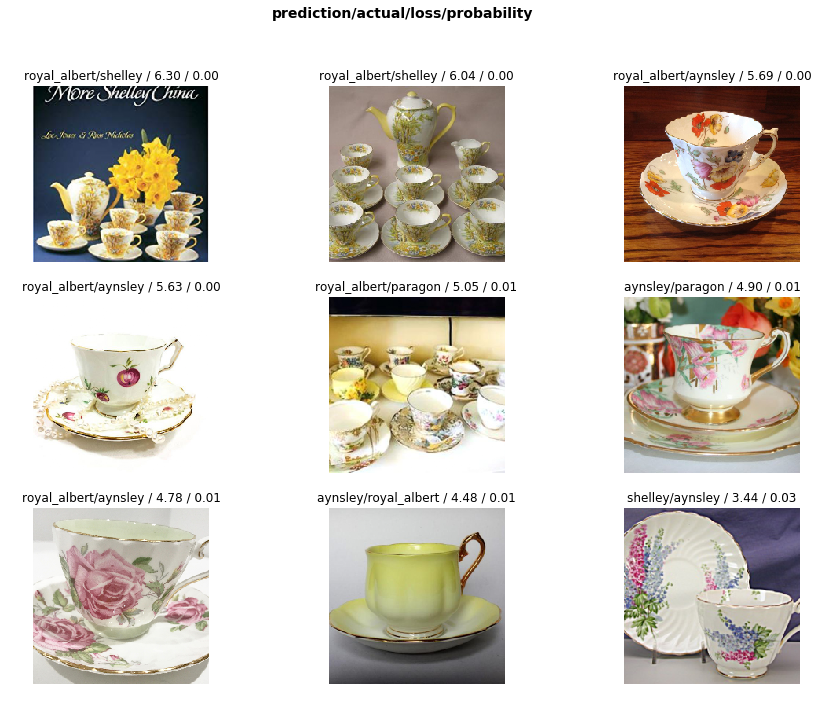

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

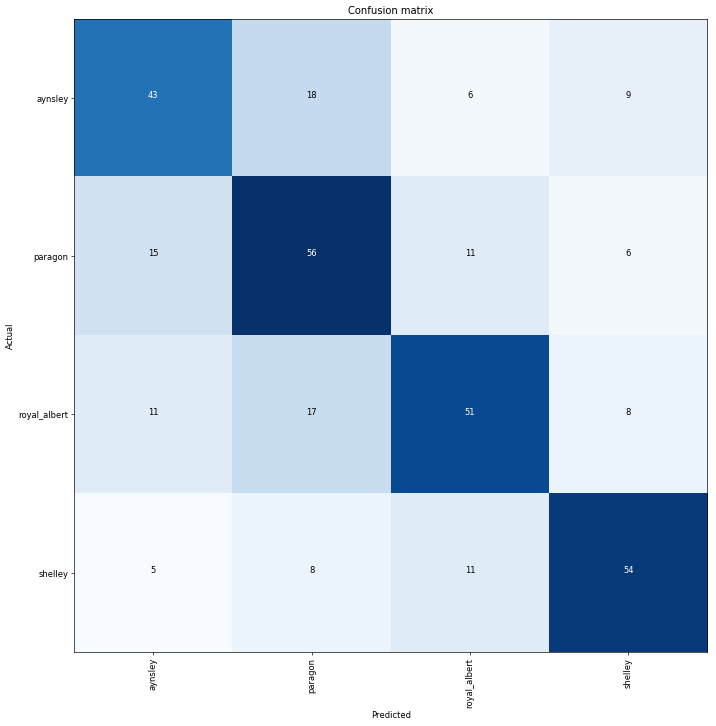

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('aynsley', 'paragon', 18),
 ('royal_albert', 'paragon', 17),
 ('paragon', 'aynsley', 15),
 ('paragon', 'royal_albert', 11),
 ('royal_albert', 'aynsley', 11),
 ('shelley', 'royal_albert', 11),
 ('aynsley', 'shelley', 9),
 ('royal_albert', 'shelley', 8),
 ('shelley', 'paragon', 8),
 ('aynsley', 'royal_albert', 6),
 ('paragon', 'shelley', 6),
 ('shelley', 'aynsley', 5)]

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the FileDeleter widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [19]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

Now we can pass in these paths to our widget.

In [20]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The File_Deleter will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(1)

Total time: 00:16
epoch  train_loss  valid_loss  error_rate
1      1.173895    1.401564    0.440729    (00:16)



In [23]:
learn.load('stage-1')

In [24]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


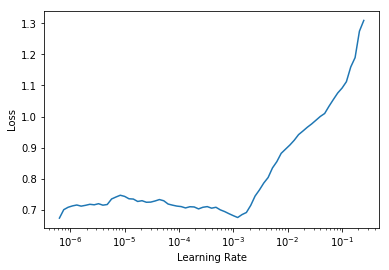

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

Total time: 01:09
epoch  train_loss  valid_loss  error_rate
1      0.723043    0.954078    0.367781    (00:17)
2      0.703757    0.928919    0.346505    (00:17)
3      0.678566    0.912924    0.349544    (00:17)
4      0.667697    0.910404    0.355623    (00:17)



In [27]:
learn.save('stage-2')

## Interprepretation

In [28]:
learn.load('stage-2')

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

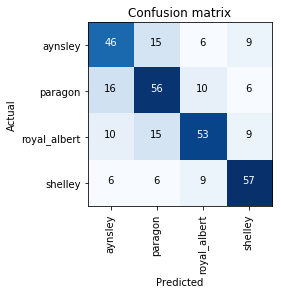

In [30]:
interp.plot_confusion_matrix()

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [31]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=10)
data.normalize(imagenet_stats)

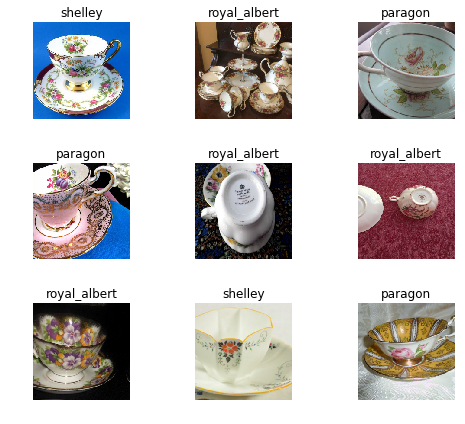

In [32]:
data.show_batch(rows=3, figsize=(7,6))

In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [34]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 02:39
epoch  train_loss  valid_loss  error_rate
1      1.345562    1.054929    0.426997    (00:22)
2      1.205152    1.115303    0.440771    (00:19)
3      1.086263    0.997729    0.399449    (00:19)
4      0.887365    0.924036    0.366391    (00:19)
5      0.799944    0.901347    0.344353    (00:19)
6      0.708710    0.917299    0.358127    (00:19)
7      0.644798    0.874574    0.330578    (00:19)
8      0.613212    0.855787    0.330578    (00:19)



In [35]:
learn.save('stage-1-50')

In [36]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 01:20
epoch  train_loss  valid_loss  error_rate
1      0.611505    0.901741    0.349862    (00:28)
2      0.581899    0.867942    0.336088    (00:26)
3      0.490148    0.853375    0.327824    (00:26)



In [37]:
interp = ClassificationInterpretation.from_learner(learn)

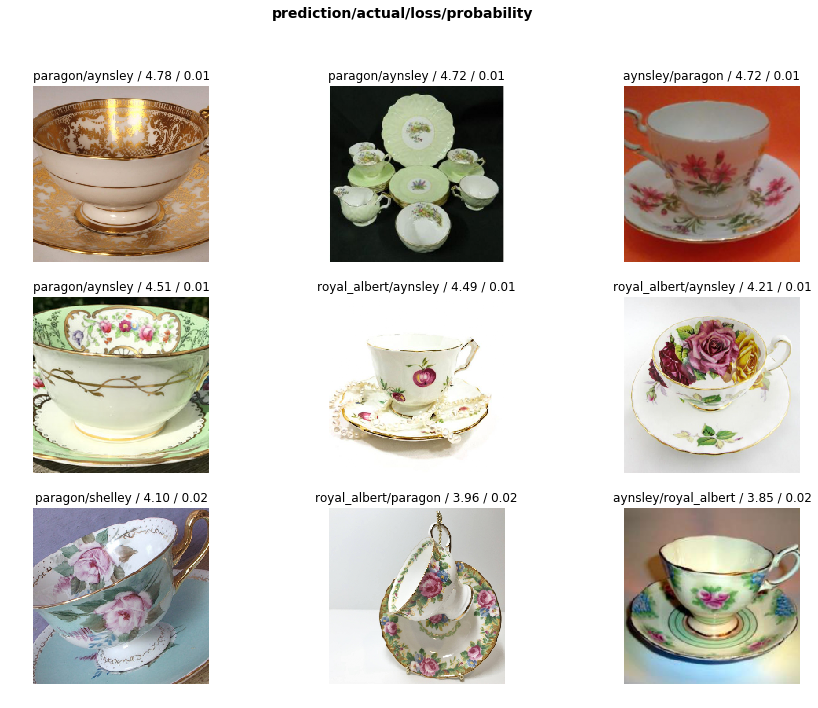

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

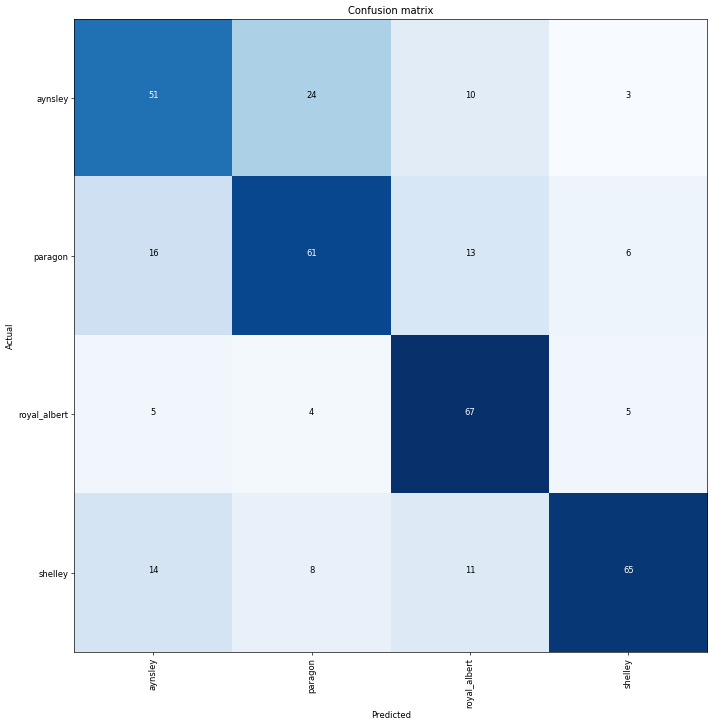

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
interp.most_confused(min_val=2)

[('aynsley', 'paragon', 24),
 ('paragon', 'aynsley', 16),
 ('shelley', 'aynsley', 14),
 ('paragon', 'royal_albert', 13),
 ('shelley', 'royal_albert', 11),
 ('aynsley', 'royal_albert', 10),
 ('shelley', 'paragon', 8),
 ('paragon', 'shelley', 6),
 ('royal_albert', 'aynsley', 5),
 ('royal_albert', 'shelley', 5),
 ('royal_albert', 'paragon', 4),
 ('aynsley', 'shelley', 3)]